<a href="https://colab.research.google.com/github/skyshine460/GHG_Direct_Emissions/blob/main/submit_ghg37.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 初期設定

In [2]:
pip install pygeohash

  Preparing metadata (setup.py) ... done
  Created wheel for pygeohash: filename=pygeohash-1.2.0-py2.py3-none-any.whl size=6153 sha256=b587fccfa532ed56a2f8b67b24b93d74d7003e82621c7b7e44e1ee655185ae07
  Stored in directory: /root/.cache/pip/wheels/28/ec/b6/beadf7295a623f528507691fb0d471b50d064ae9bbad420b8f
Successfully built pygeohash


In [3]:
pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.5 MB/s eta 0:00:00


In [4]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from tqdm import tqdm
import joblib
import math

import pygeohash as pgh

from concurrent.futures import ThreadPoolExecutor

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import KFold
from sklearn.metrics import *
from sklearn.preprocessing import LabelEncoder

import gc
gc.collect()

import os

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# データの読み込み

In [6]:
# 予測モデルを訓練するためのデータセット
train_df = pd.read_csv('/content/drive/MyDrive/GHGの排出量の予測にチャレンジしよう！（SMBC Group GREEN×DATA Challenge 2024）/提供データ/train.csv')

# 予測モデルに推論（予測)させるデータセット
test_df = pd.read_csv('/content/drive/MyDrive/GHGの排出量の予測にチャレンジしよう！（SMBC Group GREEN×DATA Challenge 2024）/提供データ/test.csv')

In [7]:
# 各カラムのデータ型と欠損値（nan）を表示
def information_df(df):
    pd.set_option('display.max_rows', None)
    type_series = df.dtypes
    nunique_series = df.nunique()
    nan_count_series = df.isnull().sum()
    unique_values_series = df.apply(lambda col: list(col.unique()))
    info_df = pd.DataFrame({
        'dtypes': type_series,
        'NaN Count': nan_count_series,
        'Nunique': nunique_series,
        'Unique Values': unique_values_series,
    })
    print(df.shape)
    return info_df

def normal_distribution_fit(df, col):

    # 正規分布のフィッティング
    from scipy.stats import norm
    from scipy import stats
    import matplotlib.pyplot as plt
    import seaborn as sns

    fig, ax = plt.subplots(1, 2, figsize=(12, 4))

    # カテゴリデータかどうかを判定
    if df[col].dtype == 'object' or df[col].dtype.name == 'category':
        # カテゴリデータの場合
        sns.countplot(x=df[col], ax=ax[0])
        ax[0].set_title('Bar Plot of Categorical Data')
    else:
        # 数値データの場合
        sns.histplot(df[col], kde=True, stat='density', ax=ax[0])
        # 正規分布のフィット
        sns.histplot(df[col], stat='density', ax=ax[0], bins=30)
        x = np.linspace(df[col].min(), df[col].max(), 100)
        ax[0].plot(x, norm.pdf(x, df[col].mean(), df[col].std()), color='red')
        ax[0].set_title('Histogram with Normal Distribution Fit')

        # Q-Qプロット
        stats.probplot(df[col], plot=ax[1])
        ax[1].set_title('Q-Q Plot')

    plt.tight_layout()
    plt.show()

    # 数値データの場合のみ歪度と尖度を計算
    if df[col].dtype != 'object' and df[col].dtype.name != 'category':
        print(f"Skewness: {df[col].skew()}")
        print(f"Kurtosis: {df[col].kurt()}")

    # 欠損値の確認
    print(f"isnull: {df[col].isnull().sum()}")

In [8]:
information_df(train_df)

(4655, 22)


,dtypes,NaN Count,Nunique,Unique Values
Unnamed: 0,int64,0,4655,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
FacilityName,object,0,4531,"[VISCOFAN USA INC, CORNWELL STATION - DOMINION..."
Latitude,float64,102,4492,"[40.141389, 38.475305, 39.29982, 35.490363, 41..."
Longitude,float64,102,4486,"[-87.581111, -81.278957, -80.85717, -119.04295..."
LocationAddress,object,179,4435,"[915 N MICHIGAN AVE, 200 RIVER HAVEN ROAD, 304..."
City,object,0,2588,"[DANVILLE, CLENDENIN, GREENWOOD, BAKERSFIELD, ..."
State,object,0,54,"[IL, WV, CA, OH, OK, NM, TN, LA, TX, IN, NC, M..."
ZIP,object,0,3758,"[61832, 25045-9304, 26415, 93308, 441031047, 7..."
County,object,70,1165,"[VERMILION, KANAWHA, RITCHIE, KERN, CUYAHOGA, ..."
FIPScode,float64,73,1646,"[17183.0, 54039.0, 54085.0, 6029.0, 39035.0, 4..."


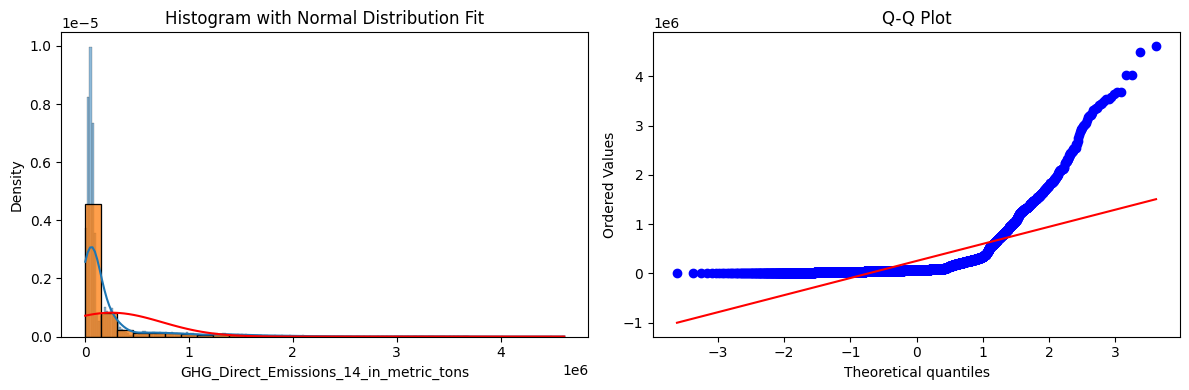

Skewness: 3.6649052199295338
Kurtosis: 16.560320863687245
isnull: 0


In [9]:
normal_distribution_fit(train_df, 'GHG_Direct_Emissions_14_in_metric_tons')

評価指標はRMSLEであり、ヒストグラムも右に裾が長いグラフなので、対数変換を行う。

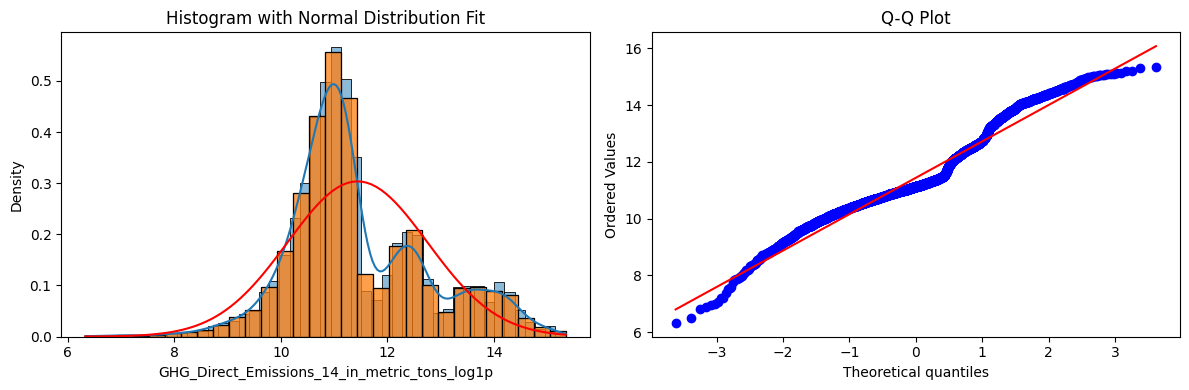

In [10]:
train_df['GHG_Direct_Emissions_14_in_metric_tons_log1p'] = np.log1p(train_df['GHG_Direct_Emissions_14_in_metric_tons'])
normal_distribution_fit(train_df, 'GHG_Direct_Emissions_14_in_metric_tons_log1p')

In [11]:
information_df(test_df)

Skewness: 0.545884275422693
Kurtosis: 0.3515490436747801
isnull: 0
(2508, 21)


,dtypes,NaN Count,Nunique,Unique Values
Unnamed: 0,int64,0,2508,"[4655, 4656, 4657, 4658, 4659, 4660, 4661, 466..."
FacilityName,object,0,2462,"[ROGER AOTSCHEGAROW, EPNG STATION 6543 LORDSBU..."
Latitude,float64,56,2437,"[38.03304, 32.31603, 41.2515, 44.95966, 32.818..."
Longitude,float64,56,2435,"[-97.97317, -108.6068, -78.74244, -93.19341, -..."
LocationAddress,object,113,2386,"[1910 SOUTH BROADACRES ROAD, nan, 3831 ROUTE 2..."
City,object,0,1647,"[HUTCHINSON, LORDSBURG, BROCKPORT, SAINT PAUL,..."
State,object,0,54,"[KS, NM, PA, MN, CA, MS, MT, AZ, IN, NY, IL, F..."
ZIP,object,0,2152,"[67501, 88045, 15823, 551141895, 92123, 38606,..."
County,object,45,865,"[RENO, HIDALGO, JEFFERSON, RAMSEY, SAN DIEGO, ..."
FIPScode,float64,45,1162,"[20155.0, 35023.0, 42065.0, 27123.0, 6073.0, 2..."


In [12]:
def merge_train_test(df_train, df_test):
    if "is_train" not in df_test.columns.tolist():
        df_train["is_train"] = 100
        df_test["is_train"] = -100
    res = pd.concat([df_train, df_test])
    res.reset_index(inplace=True, drop=True)
    return res

def split_train_test(df):
    df_train = df[df["is_train"] != -100]
    df_test = df[df["is_train"] == -100]
    df_train.reset_index(inplace=True, drop=True)
    df_test.reset_index(inplace=True, drop=True)
    return df_train, df_test

df = merge_train_test(train_df, test_df)

In [13]:
# object型をカテゴリ型に変換する
for col in df.columns:
    if df[col].dtype == "object":  # object型の列を探す
        df[col] = df[col].astype("category")  # カテゴリ型に変換

# Locationにかかわる特徴量

In [14]:
# import folium
# import matplotlib.cm as cm
# import matplotlib.colors as colors
# from IPython.display import display

# # 必要なデータを抽出し、新しいデータフレームを作成
# data = train_df[['Latitude', 'Longitude', 'GHG_Direct_Emissions_14_in_metric_tons']].copy()

# # 緯度、経度、排出量のいずれかが欠損している行を削除
# data.dropna(subset=['Latitude', 'Longitude', 'GHG_Direct_Emissions_14_in_metric_tons'], inplace=True)

# # 各列のデータ型を float に変換
# for col in ['Latitude', 'Longitude', 'GHG_Direct_Emissions_14_in_metric_tons']:
#     data[col] = data[col].astype(float)

# # 地図の中心をデータの緯度と経度の平均位置に設定
# map_center = [data['Latitude'].mean(), data['Longitude'].mean()]
# m = folium.Map(location=map_center, zoom_start=5)

# # 排出量の最大値と最小値を取得
# max_emission = data['GHG_Direct_Emissions_14_in_metric_tons'].max()
# min_emission = data['GHG_Direct_Emissions_14_in_metric_tons'].min()

# # カラーマップを設定（排出量が少ない地点は黄色、多い地点は赤色で表示）
# colormap = cm.get_cmap('YlOrRd')
# normalize = colors.Normalize(vmin=min_emission, vmax=max_emission)

# # 各地点に対して、排出量に応じた色の円マーカーを作成し地図に追加
# for idx, row in data.iterrows():
#     # 排出量に基づいて色を設定
#     color = colors.rgb2hex(colormap(normalize(row['GHG_Direct_Emissions_14_in_metric_tons'])))

#     # 円マーカーを作成
#     folium.CircleMarker(
#         location=[row['Latitude'], row['Longitude']],  # 緯度・経度
#         radius=5,  # 円のサイズ
#         popup=f"Emissions: {row['GHG_Direct_Emissions_14_in_metric_tons']}",  # ポップアップに排出量を表示
#         color=color,  # 枠の色
#         fill=True,  # 円を塗りつぶす
#         fill_color=color  # 塗りつぶしの色
#     ).add_to(m)

# # 地図を表示（Jupyter Notebook 上で表示可能）
# display(m)


GHGが高い場所はまばら。地域差や業種に集約できる可能性はあり。
欠損値はそのままとして進める。

# industryにかかわる特徴量

'PrimaryNAICS'について

数字に応じたグループあり。
特に最初の2文字が業種を表す。

In [15]:
naics_types      = {11: 'Agriculture, Forestry, Fishing and Hunting',
                    21: 'Mining, Quarrying, and Oil and Gas Extraction',
                    22: 'Utilities',
                    23: 'Construction',
                    31: 'Manufacturing',
                    32: 'Manufacturing',
                    33: 'Manufacturing',
                    42: 'Wholesale Trade',
                    44: 'Retail Trade',
                    45: 'Retail Trade',
                    48: 'Transportation and Warehousing',
                    49: 'Transportation and Warehousing',
                    51: 'Information',
                    52: 'Finance and Insurance',
                    53: 'Real Estate and Rental and Leasing',
                    54: 'Professional, Scientific, and Technical Services',
                    55: 'Management of Companies and Enterprises',
                    56: 'Administrative and Support and Waste Management and Remediation Services',
                    61: 'Educational Services',
                    62: 'Health Care and Social Assistance',
                    71: 'Arts, Entertainment, and Recreation',
                    72: 'Accommodation and Food Services',
                    81: 'Other Services (except Public Administration)',
                    92: 'Public Administration'}

In [16]:
df['PrimaryNAICS_1-2'] = df['PrimaryNAICS'].astype(str).str[:2].astype(int)
df['PrimaryNAICS_1-3'] = df['PrimaryNAICS'].astype(str).str[:3].astype(int)
df['PrimaryNAICS_1-4'] = df['PrimaryNAICS'].astype(str).str[:4].astype(int)
df['NAICS_Type'] = df['PrimaryNAICS_1-2'].map(naics_types).astype('category')

# 'na' などの変換できない値を NaN にしてから整数に変換
df['SecondPrimaryNAICS_1-2'] = pd.to_numeric(df['SecondPrimaryNAICS'].astype(str).str[:2], errors='coerce')
df['Sub_NAICS_Type'] = df['PrimaryNAICS_1-2'].map(naics_types).astype('category')

df.head()

,Unnamed: 0,FacilityName,Latitude,Longitude,LocationAddress,City,State,ZIP,County,FIPScode,...,GHG_Direct_Emissions_13_in_metric_tons,GHG_Direct_Emissions_14_in_metric_tons,GHG_Direct_Emissions_14_in_metric_tons_log1p,is_train,PrimaryNAICS_1-2,PrimaryNAICS_1-3,PrimaryNAICS_1-4,NAICS_Type,SecondPrimaryNAICS_1-2,Sub_NAICS_Type
0,0,VISCOFAN USA INC,40.141389,-87.581111,915 N MICHIGAN AVE,DANVILLE,IL,61832,VERMILION,17183.0,...,45598.125851,52973.139946,10.877559,100,32,326,3261,Manufacturing,NaN,Manufacturing
1,1,"CORNWELL STATION - DOMINION TRANSMISSION, INC",38.475305,-81.278957,200 RIVER HAVEN ROAD,CLENDENIN,WV,25045-9304,KANAWHA,54039.0,...,76376.547318,55910.066617,10.931518,100,48,486,4862,Transportation and Warehousing,NaN,Transportation and Warehousing
2,2,WEST UNION COMPRESSOR STATION,39.299820,-80.857170,3041 LONG RUN RD.,GREENWOOD,WV,26415,RITCHIE,54085.0,...,NaN,55679.543214,10.927386,100,21,211,2111,"Mining, Quarrying, and Oil and Gas Extraction",NaN,"Mining, Quarrying, and Oil and Gas Extraction"
3,3,"DOUBLE ""C"" LIMITED",35.490363,-119.042957,10245 OILFIELD ROAD,BAKERSFIELD,CA,93308,KERN,6029.0,...,53799.011225,61411.902782,11.025375,100,22,221,2211,Utilities,NaN,Utilities
4,4,LAKESHORE PLANT,41.532802,-81.636448,6800 S MARGINAL RD,CLEVELAND,OH,441031047,CUYAHOGA,39035.0,...,17662.966241,43100.469774,10.671312,100,22,221,2211,Utilities,NaN,Utilities


数値の大きさに大きな意味はなさそうなので、categoryか新しい特徴量として使用するのが良いかもしれない。

In [17]:
def create_features1(df):

    df['TRI_diff_11-10'] = df['TRI_Air_Emissions_11_in_lbs'] - df['TRI_Air_Emissions_10_in_lbs']
    df['TRI_diff_12-11'] = df['TRI_Air_Emissions_12_in_lbs'] - df['TRI_Air_Emissions_11_in_lbs']
    df['TRI_diff_13-12'] = df['TRI_Air_Emissions_13_in_lbs'] - df['TRI_Air_Emissions_12_in_lbs']

    df['TRI_Growth_Rate_11'] = np.where(
        df['TRI_Air_Emissions_10_in_lbs'].notna() & (df['TRI_Air_Emissions_10_in_lbs'] != 0),
        (df['TRI_Air_Emissions_11_in_lbs'] - df['TRI_Air_Emissions_10_in_lbs']) / df['TRI_Air_Emissions_10_in_lbs'],
        np.nan
    )

    df['TRI_Growth_Rate_12'] = np.where(
        df['TRI_Air_Emissions_11_in_lbs'].notna() & (df['TRI_Air_Emissions_11_in_lbs'] != 0),
        (df['TRI_Air_Emissions_12_in_lbs'] - df['TRI_Air_Emissions_11_in_lbs']) / df['TRI_Air_Emissions_11_in_lbs'],
        np.nan
    )

    df['TRI_Growth_Rate_13'] = np.where(
        df['TRI_Air_Emissions_12_in_lbs'].notna() & (df['TRI_Air_Emissions_12_in_lbs'] != 0),
        (df['TRI_Air_Emissions_13_in_lbs'] - df['TRI_Air_Emissions_12_in_lbs']) / df['TRI_Air_Emissions_12_in_lbs'],
        np.nan
    )

    return df

df       = create_features1(df)
new_features1 = ['TRI_diff_11-10','TRI_diff_12-11','TRI_diff_13-12', 'TRI_Growth_Rate_11','TRI_Growth_Rate_12','TRI_Growth_Rate_13']

In [18]:
train_distance = pd.read_csv('/content/drive/MyDrive/GHGの排出量の予測にチャレンジしよう！（SMBC Group GREEN×DATA Challenge 2024）/特徴量/train_distance_5nbrs_.csv')
test_distance = pd.read_csv('/content/drive/MyDrive/GHGの排出量の予測にチャレンジしよう！（SMBC Group GREEN×DATA Challenge 2024）/特徴量/test_distance_5nbrs_.csv')

In [19]:
# def haversine(lat1, lon1, lat2, lon2):
#     # Convert latitude and longitude from degrees to radians
#     lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])

#     # Haversine formula
#     dlat = lat2 - lat1
#     dlon = lon2 - lon1
#     a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
#     c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

#     # Radius of Earth in kilometers (mean radius)
#     R = 6371.0

#     # Calculate the distance
#     distance = R * c
#     return distance

# def calculate_distance(lat1, lon1, lat2, lon2):
#     return haversine(lat1, lon1, lat2, lon2)

# def get_nearest_distance(lat1, lon1, econ_sector_ref, neighbours=5, train_point=False):
#     # Extract the required columns once to NumPy arrays
#     latitudes = train_df['Latitude'].values
#     longitudes = train_df['Longitude'].values
#     ghg_emissions = train_df['GHG_Direct_Emissions_14_in_metric_tons'].values
#     econ_sectors = train_df['NAICS_Type'].values

#     # Filter NaN emissions directly
#     valid_indices = ~np.isnan(ghg_emissions)

#     latitudes = latitudes[valid_indices]
#     longitudes = longitudes[valid_indices]
#     ghg_emissions = ghg_emissions[valid_indices]
#     econ_sectors = econ_sectors[valid_indices]

#     # Parallelize distance calculation using ThreadPoolExecutor
#     with ThreadPoolExecutor() as executor:
#         distances = list(executor.map(calculate_distance,
#                                      [lat1]*len(latitudes),
#                                      [lon1]*len(longitudes),
#                                      latitudes,
#                                      longitudes))

#     # Combine the results into a DataFrame
#     near_df = pd.DataFrame({
#         'Distance': distances,
#         'GHG_emission_14': ghg_emissions,
#         'Economic_Sector': econ_sectors
#     })


#     if train_point:
#         near_df.sort_values(by='Distance', inplace=True)
#         near_df = near_df.dropna()
#         near_df = near_df.iloc[1:].reset_index(drop=True)
#     else:
#         # Sort distances by 'Distance'
#         near_df.sort_values(by='Distance', inplace=True)
#         near_df = near_df.dropna()

#     # Filter by economic sector
#     nearest_locations_econ_sector = near_df[near_df['Economic_Sector'] == econ_sector_ref]

#     # Get the top N nearest for both economic sector and overall
#     sub_near_econ = nearest_locations_econ_sector.head(neighbours)
#     sub_nearest_locations = near_df.head(neighbours)

#     # Compute weighted averages
#     econ_weighted_average = (sub_near_econ['GHG_emission_14'] / np.where(sub_near_econ['Distance'] == 0, 1, sub_near_econ['Distance']) ).sum()
#     near_weighted_average = (sub_nearest_locations['GHG_emission_14'] / np.where(sub_nearest_locations['Distance']==0,1,sub_nearest_locations['Distance'])).sum()

#     # Compute regular averages
#     econ_average = sub_near_econ['GHG_emission_14'].mean()
#     near_average = sub_nearest_locations['GHG_emission_14'].mean()

#     return [econ_weighted_average, econ_average, near_weighted_average, near_average]

In [20]:
# neighbours = 5

# file_path = f"test_distance_{neighbours}nbrs.csv"
# if os.path.exists(file_path):
#     print(f"{file_path} exists. ")
#     test_distance = pd.read_csv(f"test_distance_{neighbours}nbrs.csv")
# else:
#     output = []
#     for index in tqdm(range(test_df.shape[0])):

#         lat1 = test_df.iloc[index]['Latitude']
#         lon1 = test_df.iloc[index]['Longitude']
#         econ_sector_ref = test_df.iloc[index]['NAICS_Type']
#         x = get_nearest_distance(lat1,lon1,econ_sector_ref,neighbours=neighbours,train_point=False)
#         output.append(x)
#     test_distance = pd.DataFrame(output,columns = ['Economy_Sector_Weighted_Avg','Economic_Sector_Average','Nearest_Weighted_Average','Nearest_Average'])
#     test_distance.to_csv(f'test_distance_{neighbours}nbrs.csv',index=False)

# file_path = f"train_distance_{neighbours}nbrs.csv"
# if os.path.exists(file_path):
#     print(f"{file_path} exists. ")
#     train_distance = pd.read_csv(f'train_distance_{neighbours}nbrs.csv')
# else:
#     output = []
#     for index in tqdm(range(train_df.shape[0])):
#         lat1 = train_df.iloc[index]['Latitude']
#         lon1 = train_df.iloc[index]['Longitude']
#         econ_sector_ref = train_df.iloc[index]['NAICS_Type']
#         x = get_nearest_distance(lat1,lon1,econ_sector_ref,neighbours=neighbours, train_point=True)
#         output.append(x)
#     train_distance = pd.DataFrame(output,columns = ['Economy_Sector_Weighted_Avg','Economic_Sector_Average','Nearest_Weighted_Average','Nearest_Average'])
#     train_distance.to_csv(f'train_distance_{neighbours}nbrs.csv',index=False)

train_df, test_df = split_train_test(df)
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)
train_df = pd.concat((train_df,train_distance),axis=1)

# インデックスをリセットしてから結合
test_df = test_df.reset_index(drop=True)
test_distance = test_distance.reset_index(drop=True)
test_df = pd.concat((test_df, test_distance), axis=1)

# train_df['Economy_Sector_Weighted_Avg'] = train_df['Economy_Sector_Weighted_Avg'].fillna(0)
# train_df['Economic_Sector_Average'] = train_df['Economic_Sector_Average'].fillna(0)

In [21]:
features = [
                        'TRI_Air_Emissions_10_in_lbs', 'TRI_Air_Emissions_11_in_lbs',
                    'TRI_Air_Emissions_12_in_lbs', 'TRI_Air_Emissions_13_in_lbs','PrimaryNAICS',
                    'GHG_Direct_Emissions_10_in_metric_tons', 'GHG_Direct_Emissions_11_in_metric_tons',
                    'GHG_Direct_Emissions_12_in_metric_tons', 'GHG_Direct_Emissions_13_in_metric_tons',
                        'Latitude','Longitude',
                        'TRI_diff_11-10','TRI_diff_12-11','TRI_diff_13-12', 'TRI_Growth_Rate_11','TRI_Growth_Rate_12','TRI_Growth_Rate_13',
                        'NAICS_Type',
]

In [22]:
train = train_df[features]
target = train_df['GHG_Direct_Emissions_14_in_metric_tons']
test = test_df[features]

In [23]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.6 MB/s eta 0:00:00


In [24]:
# import optuna
# from sklearn.metrics import root_mean_squared_log_error
# from xgboost import XGBRegressor
# from sklearn.model_selection import KFold
# import numpy as np
# import gc

# N_SPLITS = 15
# SEED_SKF = 42
# np.random.seed(123)

# kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED_SKF)

# def objective(trial, train, target):
#     # Optunaで探索するパラメータ
#     xgb_params = {
#         "n_estimators": trial.suggest_int("n_estimators", 300, 700),
#         "max_depth": 4,
#         "learning_rate": trial.suggest_loguniform("learning_rate", 0.005, 0.01),
#         "subsample": trial.suggest_float("subsample", 0.6, 0.8),
#         "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 0.8),
#         "reg_alpha": trial.suggest_loguniform("reg_alpha", 0.01, 10.0),
#         "reg_lambda": trial.suggest_loguniform("reg_lambda", 1.0, 10.0),
#         "random_state": 123,
#         'enable_categorical': True,
#     }

#     oof_predictions = np.zeros(len(train))
#     fold_rmsle = []
#     train_predictions = np.zeros(len(train))

#     for fold, (train_index, valid_index) in enumerate(kf.split(train, target)):
#         X_train, X_valid = train.iloc[train_index], train.iloc[valid_index]
#         y_train, y_valid = target.iloc[train_index], target.iloc[valid_index]

#         model = XGBRegressor(**xgb_params)
#         _ = model.fit(X_train, np.log1p(y_train))

#         valid_preds = np.expm1(model.predict(X_valid))
#         train_preds = np.expm1(model.predict(X_train))

#         rmsle_valid = root_mean_squared_log_error(y_valid, valid_preds)
#         rmsle_train = root_mean_squared_log_error(y_train, train_preds)

#         oof_predictions[valid_index] = valid_preds
#         train_predictions[train_index] = train_preds

#         print(f"Fold {fold} - Train RMSLE: {rmsle_train:.5f}, Valid RMSLE: {rmsle_valid:.5f}")

#     RMSLE = root_mean_squared_log_error(target, oof_predictions)
#     tr_RMSLE = root_mean_squared_log_error(target, train_predictions)
#     print(f"[CV] tr:{tr_RMSLE:.5f} va:{RMSLE:.5f}")
#     print("-" * 50)



#     return RMSLE


# # Optunaでのハイパーパラメータ最適化
# study = optuna.create_study(direction="minimize")
# study.optimize(lambda trial: objective(trial, train, target), n_trials=10)

# # 最良のパラメータをリストに格納
# params_list = [trial.params for trial in study.trials]

# # 選択した範囲のRMSLEスコアを格納するリスト
# valid_params_with_rmsle = []


In [32]:
import optuna
from sklearn.metrics import mean_squared_log_error
from lightgbm import LGBMRegressor
import lightgbm as lgb
from sklearn.model_selection import KFold
import numpy as np
import gc

N_SPLITS = 15
SEED_SKF = 42
np.random.seed(42)

kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED_SKF)

def objective(trial, train, target, num_folds=5):
    # Optunaで探索するパラメータ
    lgbm_params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 100),
        "max_depth": 3,
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.05, 0.5),
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 0.01, 0.1),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1.0, 5.0),
        "random_state": 42,
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'verbose': -1,
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 30, 50),
        "max_bin": trial.suggest_int("max_bin", 150, 200),
    }

    oof_predictions = np.zeros(len(train))
    fold_rmsle = []
    train_predictions = np.zeros(len(train))

    for fold, (train_index, valid_index) in enumerate(kf.split(train, target)):
        X_train, X_valid = train.iloc[train_index], train.iloc[valid_index]
        y_train, y_valid = target.iloc[train_index], target.iloc[valid_index]

        model = LGBMRegressor(**lgbm_params)
        model.fit(
            X_train,
            np.log1p(y_train),
            eval_set=[(X_valid, y_valid)],
            callbacks=[
                lgb.early_stopping(stopping_rounds=50, verbose=False),
                lgb.log_evaluation(0)],
        )
        valid_preds = np.expm1(model.predict(X_valid))
        train_preds = np.expm1(model.predict(X_train))

        rmsle_valid = mean_squared_log_error(y_valid, valid_preds, squared=False)
        rmsle_train = mean_squared_log_error(y_train, train_preds, squared=False)

        oof_predictions[valid_index] = valid_preds
        train_predictions[train_index] = train_preds

        print(f"Fold {fold} - Train RMSLE: {rmsle_train:.5f}, Valid RMSLE: {rmsle_valid:.5f}")

    RMSLE = root_mean_squared_log_error(target, oof_predictions)
    tr_RMSLE = root_mean_squared_log_error(target, train_predictions)
    print(f"[CV] tr:{tr_RMSLE:.5f} va:{RMSLE:.5f}")
    print("-" * 50)

    return RMSLE

# Optunaでのハイパーパラメータ最適化
study = optuna.create_study(direction="minimize")
study.optimize(lambda trial: objective(trial, train, target), n_trials=20)

# 最良のパラメータをリストに格納
params_list = [trial.params for trial in study.trials]

# 選択した範囲のRMSLEスコアを格納するリスト
valid_params_with_rmsle = []


[I 2024-12-01 14:39:23,367] A new study created in memory with name: no-name-530ec90c-3545-4619-917d-d8bfbbd9a20b


Fold 0 - Train RMSLE: 0.72223, Valid RMSLE: 0.68582
Fold 1 - Train RMSLE: 0.71515, Valid RMSLE: 0.78786
Fold 2 - Train RMSLE: 0.71644, Valid RMSLE: 0.76705
Fold 3 - Train RMSLE: 0.72016, Valid RMSLE: 0.68810
Fold 4 - Train RMSLE: 0.71657, Valid RMSLE: 0.76268
Fold 5 - Train RMSLE: 0.71538, Valid RMSLE: 0.78337
Fold 6 - Train RMSLE: 0.71759, Valid RMSLE: 0.74041
Fold 7 - Train RMSLE: 0.71705, Valid RMSLE: 0.76401
Fold 8 - Train RMSLE: 0.71118, Valid RMSLE: 0.82937
Fold 9 - Train RMSLE: 0.71294, Valid RMSLE: 0.81160
Fold 10 - Train RMSLE: 0.71725, Valid RMSLE: 0.76458
Fold 11 - Train RMSLE: 0.71597, Valid RMSLE: 0.74305
Fold 12 - Train RMSLE: 0.71895, Valid RMSLE: 0.72156
Fold 13 - Train RMSLE: 0.71382, Valid RMSLE: 0.78958


[I 2024-12-01 14:39:25,700] Trial 0 finished with value: 0.7610510737448782 and parameters: {'n_estimators': 77, 'learning_rate': 0.09248719899827025, 'lambda_l1': 0.018150512279166024, 'lambda_l2': 2.332805140424431, 'min_data_in_leaf': 35, 'max_bin': 153}. Best is trial 0 with value: 0.7610510737448782.


Fold 14 - Train RMSLE: 0.71436, Valid RMSLE: 0.76222
[CV] tr:0.71488 va:0.76105
--------------------------------------------------
Fold 0 - Train RMSLE: 0.71124, Valid RMSLE: 0.68636
Fold 1 - Train RMSLE: 0.70534, Valid RMSLE: 0.78462
Fold 2 - Train RMSLE: 0.70617, Valid RMSLE: 0.77665
Fold 3 - Train RMSLE: 0.71249, Valid RMSLE: 0.69441
Fold 4 - Train RMSLE: 0.70520, Valid RMSLE: 0.75998
Fold 5 - Train RMSLE: 0.70481, Valid RMSLE: 0.78469
Fold 6 - Train RMSLE: 0.70633, Valid RMSLE: 0.74960
Fold 7 - Train RMSLE: 0.70543, Valid RMSLE: 0.77093
Fold 8 - Train RMSLE: 0.70051, Valid RMSLE: 0.82413
Fold 9 - Train RMSLE: 0.70657, Valid RMSLE: 0.81547
Fold 10 - Train RMSLE: 0.70594, Valid RMSLE: 0.76554
Fold 11 - Train RMSLE: 0.70644, Valid RMSLE: 0.74484
Fold 12 - Train RMSLE: 0.70860, Valid RMSLE: 0.71977
Fold 13 - Train RMSLE: 0.70306, Valid RMSLE: 0.78388


[I 2024-12-01 14:39:28,971] Trial 1 finished with value: 0.7623338229433306 and parameters: {'n_estimators': 94, 'learning_rate': 0.11455799275223255, 'lambda_l1': 0.03698426305022695, 'lambda_l2': 1.4675636961074723, 'min_data_in_leaf': 43, 'max_bin': 187}. Best is trial 0 with value: 0.7610510737448782.


Fold 14 - Train RMSLE: 0.70422, Valid RMSLE: 0.76065
[CV] tr:0.70500 va:0.76233
--------------------------------------------------
Fold 0 - Train RMSLE: 0.70841, Valid RMSLE: 0.68808
Fold 1 - Train RMSLE: 0.70611, Valid RMSLE: 0.79662
Fold 2 - Train RMSLE: 0.70274, Valid RMSLE: 0.76862
Fold 3 - Train RMSLE: 0.70594, Valid RMSLE: 0.69118
Fold 4 - Train RMSLE: 0.70181, Valid RMSLE: 0.75985
Fold 5 - Train RMSLE: 0.70376, Valid RMSLE: 0.77582
Fold 6 - Train RMSLE: 0.71694, Valid RMSLE: 0.74581
Fold 7 - Train RMSLE: 0.70610, Valid RMSLE: 0.77045
Fold 8 - Train RMSLE: 0.70380, Valid RMSLE: 0.82288
Fold 9 - Train RMSLE: 0.69872, Valid RMSLE: 0.81267
Fold 10 - Train RMSLE: 0.70628, Valid RMSLE: 0.77577
Fold 11 - Train RMSLE: 0.70504, Valid RMSLE: 0.73784
Fold 12 - Train RMSLE: 0.70956, Valid RMSLE: 0.72381


[I 2024-12-01 14:39:30,764] Trial 2 finished with value: 0.7623180043646515 and parameters: {'n_estimators': 66, 'learning_rate': 0.1853689715989547, 'lambda_l1': 0.052670266342636544, 'lambda_l2': 2.1278978971568936, 'min_data_in_leaf': 40, 'max_bin': 182}. Best is trial 0 with value: 0.7610510737448782.


Fold 13 - Train RMSLE: 0.70175, Valid RMSLE: 0.78622
Fold 14 - Train RMSLE: 0.70988, Valid RMSLE: 0.76547
[CV] tr:0.71028 va:0.76232
--------------------------------------------------
Fold 0 - Train RMSLE: 0.72885, Valid RMSLE: 0.68385
Fold 1 - Train RMSLE: 0.72350, Valid RMSLE: 0.78163
Fold 2 - Train RMSLE: 0.72459, Valid RMSLE: 0.76410
Fold 3 - Train RMSLE: 0.72754, Valid RMSLE: 0.68521
Fold 4 - Train RMSLE: 0.72396, Valid RMSLE: 0.75942
Fold 5 - Train RMSLE: 0.72368, Valid RMSLE: 0.77965
Fold 6 - Train RMSLE: 0.72548, Valid RMSLE: 0.74417
Fold 7 - Train RMSLE: 0.72371, Valid RMSLE: 0.76613
Fold 8 - Train RMSLE: 0.71950, Valid RMSLE: 0.83128
Fold 9 - Train RMSLE: 0.72082, Valid RMSLE: 0.80879
Fold 10 - Train RMSLE: 0.72476, Valid RMSLE: 0.76315
Fold 11 - Train RMSLE: 0.72494, Valid RMSLE: 0.74377
Fold 12 - Train RMSLE: 0.72718, Valid RMSLE: 0.72220
Fold 13 - Train RMSLE: 0.72218, Valid RMSLE: 0.78406


[I 2024-12-01 14:39:32,952] Trial 3 finished with value: 0.7593855416336044 and parameters: {'n_estimators': 93, 'learning_rate': 0.053890438451104215, 'lambda_l1': 0.012908770569526093, 'lambda_l2': 1.3604859414892223, 'min_data_in_leaf': 43, 'max_bin': 154}. Best is trial 3 with value: 0.7593855416336044.


Fold 14 - Train RMSLE: 0.72301, Valid RMSLE: 0.75908
[CV] tr:0.72323 va:0.75939
--------------------------------------------------
Fold 0 - Train RMSLE: 0.72142, Valid RMSLE: 0.68734
Fold 1 - Train RMSLE: 0.71573, Valid RMSLE: 0.78360
Fold 2 - Train RMSLE: 0.71864, Valid RMSLE: 0.76292
Fold 3 - Train RMSLE: 0.72203, Valid RMSLE: 0.69326
Fold 4 - Train RMSLE: 0.71559, Valid RMSLE: 0.76148
Fold 5 - Train RMSLE: 0.71670, Valid RMSLE: 0.77792
Fold 6 - Train RMSLE: 0.72040, Valid RMSLE: 0.74011
Fold 7 - Train RMSLE: 0.71620, Valid RMSLE: 0.76879
Fold 8 - Train RMSLE: 0.71282, Valid RMSLE: 0.83014
Fold 9 - Train RMSLE: 0.71334, Valid RMSLE: 0.81072
Fold 10 - Train RMSLE: 0.71609, Valid RMSLE: 0.76814
Fold 11 - Train RMSLE: 0.71925, Valid RMSLE: 0.74454
Fold 12 - Train RMSLE: 0.72023, Valid RMSLE: 0.72191


[I 2024-12-01 14:39:34,677] Trial 4 finished with value: 0.7608224139360394 and parameters: {'n_estimators': 63, 'learning_rate': 0.1124081049434983, 'lambda_l1': 0.012491225111900013, 'lambda_l2': 1.9973703458358918, 'min_data_in_leaf': 47, 'max_bin': 194}. Best is trial 3 with value: 0.7593855416336044.


Fold 13 - Train RMSLE: 0.71690, Valid RMSLE: 0.78991
Fold 14 - Train RMSLE: 0.71452, Valid RMSLE: 0.75794
[CV] tr:0.71522 va:0.76082
--------------------------------------------------
Fold 0 - Train RMSLE: 0.70286, Valid RMSLE: 0.69271
Fold 1 - Train RMSLE: 0.68600, Valid RMSLE: 0.79152
Fold 2 - Train RMSLE: 0.68968, Valid RMSLE: 0.78361
Fold 3 - Train RMSLE: 0.69194, Valid RMSLE: 0.69644
Fold 4 - Train RMSLE: 0.69027, Valid RMSLE: 0.76585
Fold 5 - Train RMSLE: 0.69651, Valid RMSLE: 0.79057
Fold 6 - Train RMSLE: 0.70812, Valid RMSLE: 0.74625
Fold 7 - Train RMSLE: 0.69075, Valid RMSLE: 0.76739
Fold 8 - Train RMSLE: 0.68620, Valid RMSLE: 0.82947
Fold 9 - Train RMSLE: 0.68503, Valid RMSLE: 0.81285
Fold 10 - Train RMSLE: 0.70549, Valid RMSLE: 0.76565
Fold 11 - Train RMSLE: 0.68866, Valid RMSLE: 0.74367
Fold 12 - Train RMSLE: 0.69907, Valid RMSLE: 0.73209
Fold 13 - Train RMSLE: 0.69310, Valid RMSLE: 0.79361


[I 2024-12-01 14:39:36,705] Trial 5 finished with value: 0.7667015901993033 and parameters: {'n_estimators': 92, 'learning_rate': 0.19467685285359473, 'lambda_l1': 0.06770098522198577, 'lambda_l2': 1.423128208191288, 'min_data_in_leaf': 38, 'max_bin': 180}. Best is trial 3 with value: 0.7593855416336044.


Fold 14 - Train RMSLE: 0.69633, Valid RMSLE: 0.77552
[CV] tr:0.69686 va:0.76670
--------------------------------------------------
Fold 0 - Train RMSLE: 0.70776, Valid RMSLE: 0.68295
Fold 1 - Train RMSLE: 0.69407, Valid RMSLE: 0.79406
Fold 2 - Train RMSLE: 0.70371, Valid RMSLE: 0.76313
Fold 3 - Train RMSLE: 0.70336, Valid RMSLE: 0.69347
Fold 4 - Train RMSLE: 0.70374, Valid RMSLE: 0.76312
Fold 5 - Train RMSLE: 0.69798, Valid RMSLE: 0.79050
Fold 6 - Train RMSLE: 0.69609, Valid RMSLE: 0.73972
Fold 7 - Train RMSLE: 0.70590, Valid RMSLE: 0.77688
Fold 8 - Train RMSLE: 0.69629, Valid RMSLE: 0.82981
Fold 9 - Train RMSLE: 0.69616, Valid RMSLE: 0.80958
Fold 10 - Train RMSLE: 0.70537, Valid RMSLE: 0.77045
Fold 11 - Train RMSLE: 0.69415, Valid RMSLE: 0.74073
Fold 12 - Train RMSLE: 0.70284, Valid RMSLE: 0.73485


[I 2024-12-01 14:39:38,387] Trial 6 finished with value: 0.7636122180022094 and parameters: {'n_estimators': 67, 'learning_rate': 0.21890808587519725, 'lambda_l1': 0.04042656808990016, 'lambda_l2': 2.013992277227716, 'min_data_in_leaf': 38, 'max_bin': 181}. Best is trial 3 with value: 0.7593855416336044.


Fold 13 - Train RMSLE: 0.69196, Valid RMSLE: 0.78278
Fold 14 - Train RMSLE: 0.69549, Valid RMSLE: 0.76803
[CV] tr:0.69607 va:0.76361
--------------------------------------------------
Fold 0 - Train RMSLE: 0.74046, Valid RMSLE: 0.68067
Fold 1 - Train RMSLE: 0.73324, Valid RMSLE: 0.78648
Fold 2 - Train RMSLE: 0.73569, Valid RMSLE: 0.76717
Fold 3 - Train RMSLE: 0.73985, Valid RMSLE: 0.68912
Fold 4 - Train RMSLE: 0.73450, Valid RMSLE: 0.76881
Fold 5 - Train RMSLE: 0.73371, Valid RMSLE: 0.78639
Fold 6 - Train RMSLE: 0.73645, Valid RMSLE: 0.73955
Fold 7 - Train RMSLE: 0.73416, Valid RMSLE: 0.77612
Fold 8 - Train RMSLE: 0.72948, Valid RMSLE: 0.83883
Fold 9 - Train RMSLE: 0.73285, Valid RMSLE: 0.80641
Fold 10 - Train RMSLE: 0.73561, Valid RMSLE: 0.76320
Fold 11 - Train RMSLE: 0.73600, Valid RMSLE: 0.74562
Fold 12 - Train RMSLE: 0.73811, Valid RMSLE: 0.72579
Fold 13 - Train RMSLE: 0.73386, Valid RMSLE: 0.78447


[I 2024-12-01 14:39:40,451] Trial 7 finished with value: 0.762253500896611 and parameters: {'n_estimators': 61, 'learning_rate': 0.05222760500986535, 'lambda_l1': 0.06101269125018898, 'lambda_l2': 1.8830230692692185, 'min_data_in_leaf': 34, 'max_bin': 176}. Best is trial 3 with value: 0.7593855416336044.


Fold 14 - Train RMSLE: 0.73472, Valid RMSLE: 0.75989
[CV] tr:0.73497 va:0.76225
--------------------------------------------------
Fold 0 - Train RMSLE: 0.73199, Valid RMSLE: 0.68008
Fold 1 - Train RMSLE: 0.72448, Valid RMSLE: 0.78499
Fold 2 - Train RMSLE: 0.72698, Valid RMSLE: 0.76407
Fold 3 - Train RMSLE: 0.73073, Valid RMSLE: 0.68835
Fold 4 - Train RMSLE: 0.72728, Valid RMSLE: 0.75959
Fold 5 - Train RMSLE: 0.72457, Valid RMSLE: 0.78051
Fold 6 - Train RMSLE: 0.72795, Valid RMSLE: 0.74246
Fold 7 - Train RMSLE: 0.72655, Valid RMSLE: 0.76695
Fold 8 - Train RMSLE: 0.72199, Valid RMSLE: 0.83226
Fold 9 - Train RMSLE: 0.72323, Valid RMSLE: 0.80967
Fold 10 - Train RMSLE: 0.72743, Valid RMSLE: 0.76109
Fold 11 - Train RMSLE: 0.72647, Valid RMSLE: 0.74132
Fold 12 - Train RMSLE: 0.72916, Valid RMSLE: 0.72353


[I 2024-12-01 14:39:43,005] Trial 8 finished with value: 0.7596607037305105 and parameters: {'n_estimators': 60, 'learning_rate': 0.07234069375611607, 'lambda_l1': 0.022893321178064467, 'lambda_l2': 1.3260487255031153, 'min_data_in_leaf': 42, 'max_bin': 199}. Best is trial 3 with value: 0.7593855416336044.


Fold 13 - Train RMSLE: 0.72451, Valid RMSLE: 0.78679
Fold 14 - Train RMSLE: 0.72461, Valid RMSLE: 0.75848
[CV] tr:0.72513 va:0.75966
--------------------------------------------------
Fold 0 - Train RMSLE: 0.71561, Valid RMSLE: 0.68969
Fold 1 - Train RMSLE: 0.70354, Valid RMSLE: 0.78471
Fold 2 - Train RMSLE: 0.70072, Valid RMSLE: 0.77125
Fold 3 - Train RMSLE: 0.70507, Valid RMSLE: 0.68607
Fold 4 - Train RMSLE: 0.70222, Valid RMSLE: 0.76451
Fold 5 - Train RMSLE: 0.69782, Valid RMSLE: 0.77813
Fold 6 - Train RMSLE: 0.71204, Valid RMSLE: 0.74286
Fold 7 - Train RMSLE: 0.70713, Valid RMSLE: 0.76261
Fold 8 - Train RMSLE: 0.69403, Valid RMSLE: 0.82152
Fold 9 - Train RMSLE: 0.69570, Valid RMSLE: 0.81939
Fold 10 - Train RMSLE: 0.70365, Valid RMSLE: 0.76757
Fold 11 - Train RMSLE: 0.69940, Valid RMSLE: 0.75123
Fold 12 - Train RMSLE: 0.70142, Valid RMSLE: 0.71755


[I 2024-12-01 14:39:45,666] Trial 9 finished with value: 0.7619978013892161 and parameters: {'n_estimators': 92, 'learning_rate': 0.15851213847206824, 'lambda_l1': 0.054607222079088254, 'lambda_l2': 2.478029325183729, 'min_data_in_leaf': 47, 'max_bin': 157}. Best is trial 3 with value: 0.7593855416336044.


Fold 13 - Train RMSLE: 0.69504, Valid RMSLE: 0.78969
Fold 14 - Train RMSLE: 0.70150, Valid RMSLE: 0.76910
[CV] tr:0.70186 va:0.76200
--------------------------------------------------
Fold 0 - Train RMSLE: 0.67874, Valid RMSLE: 0.71155
Fold 1 - Train RMSLE: 0.65314, Valid RMSLE: 0.79050
Fold 2 - Train RMSLE: 0.72309, Valid RMSLE: 0.77899
Fold 3 - Train RMSLE: 0.68486, Valid RMSLE: 0.71409
Fold 4 - Train RMSLE: 0.70372, Valid RMSLE: 0.76991
Fold 5 - Train RMSLE: 0.68941, Valid RMSLE: 0.80899
Fold 6 - Train RMSLE: 0.69931, Valid RMSLE: 0.75920
Fold 7 - Train RMSLE: 0.69204, Valid RMSLE: 0.79217
Fold 8 - Train RMSLE: 0.64894, Valid RMSLE: 0.83586
Fold 9 - Train RMSLE: 0.67810, Valid RMSLE: 0.81344
Fold 10 - Train RMSLE: 0.65080, Valid RMSLE: 0.78872
Fold 11 - Train RMSLE: 0.65788, Valid RMSLE: 0.75654
Fold 12 - Train RMSLE: 0.66495, Valid RMSLE: 0.74237
Fold 13 - Train RMSLE: 0.66272, Valid RMSLE: 0.80022


[I 2024-12-01 14:39:47,457] Trial 10 finished with value: 0.7755279042817789 and parameters: {'n_estimators': 81, 'learning_rate': 0.43233881839211685, 'lambda_l1': 0.010498669647678979, 'lambda_l2': 4.2614564432737065, 'min_data_in_leaf': 31, 'max_bin': 162}. Best is trial 3 with value: 0.7593855416336044.


Fold 14 - Train RMSLE: 0.73047, Valid RMSLE: 0.75949
[CV] tr:0.72762 va:0.77553
--------------------------------------------------
Fold 0 - Train RMSLE: 0.74647, Valid RMSLE: 0.68232
Fold 1 - Train RMSLE: 0.73960, Valid RMSLE: 0.78882
Fold 2 - Train RMSLE: 0.74161, Valid RMSLE: 0.76911
Fold 3 - Train RMSLE: 0.74579, Valid RMSLE: 0.69317
Fold 4 - Train RMSLE: 0.73971, Valid RMSLE: 0.77344
Fold 5 - Train RMSLE: 0.74006, Valid RMSLE: 0.78788
Fold 6 - Train RMSLE: 0.74235, Valid RMSLE: 0.74008
Fold 7 - Train RMSLE: 0.74092, Valid RMSLE: 0.78365
Fold 8 - Train RMSLE: 0.73593, Valid RMSLE: 0.84476
Fold 9 - Train RMSLE: 0.73805, Valid RMSLE: 0.81231
Fold 10 - Train RMSLE: 0.74176, Valid RMSLE: 0.76790
Fold 11 - Train RMSLE: 0.74265, Valid RMSLE: 0.74921
Fold 12 - Train RMSLE: 0.74363, Valid RMSLE: 0.72332


[I 2024-12-01 14:39:49,056] Trial 11 finished with value: 0.7651527503301596 and parameters: {'n_estimators': 52, 'learning_rate': 0.053014890508399755, 'lambda_l1': 0.0220584516022811, 'lambda_l2': 1.0142026521279026, 'min_data_in_leaf': 43, 'max_bin': 167}. Best is trial 3 with value: 0.7593855416336044.


Fold 13 - Train RMSLE: 0.73974, Valid RMSLE: 0.78369
Fold 14 - Train RMSLE: 0.74101, Valid RMSLE: 0.76158
[CV] tr:0.74107 va:0.76515
--------------------------------------------------
Fold 0 - Train RMSLE: 0.72463, Valid RMSLE: 0.68744
Fold 1 - Train RMSLE: 0.71780, Valid RMSLE: 0.78338
Fold 2 - Train RMSLE: 0.72057, Valid RMSLE: 0.76771
Fold 3 - Train RMSLE: 0.72262, Valid RMSLE: 0.69247
Fold 4 - Train RMSLE: 0.71953, Valid RMSLE: 0.76091
Fold 5 - Train RMSLE: 0.71694, Valid RMSLE: 0.78319
Fold 6 - Train RMSLE: 0.72098, Valid RMSLE: 0.74573
Fold 7 - Train RMSLE: 0.71847, Valid RMSLE: 0.76490
Fold 8 - Train RMSLE: 0.71459, Valid RMSLE: 0.83028
Fold 9 - Train RMSLE: 0.71595, Valid RMSLE: 0.81158
Fold 10 - Train RMSLE: 0.71982, Valid RMSLE: 0.75880
Fold 11 - Train RMSLE: 0.71998, Valid RMSLE: 0.74145
Fold 12 - Train RMSLE: 0.72323, Valid RMSLE: 0.72361
Fold 13 - Train RMSLE: 0.71756, Valid RMSLE: 0.78475


[I 2024-12-01 14:39:51,206] Trial 12 finished with value: 0.7606205295718311 and parameters: {'n_estimators': 83, 'learning_rate': 0.07394384108907685, 'lambda_l1': 0.021839289567391094, 'lambda_l2': 1.051546580352437, 'min_data_in_leaf': 43, 'max_bin': 200}. Best is trial 3 with value: 0.7593855416336044.


Fold 14 - Train RMSLE: 0.71864, Valid RMSLE: 0.75958
[CV] tr:0.71896 va:0.76062
--------------------------------------------------
Fold 0 - Train RMSLE: 0.72119, Valid RMSLE: 0.68556
Fold 1 - Train RMSLE: 0.71496, Valid RMSLE: 0.78180
Fold 2 - Train RMSLE: 0.71935, Valid RMSLE: 0.76181
Fold 3 - Train RMSLE: 0.72189, Valid RMSLE: 0.69142
Fold 4 - Train RMSLE: 0.71612, Valid RMSLE: 0.75823
Fold 5 - Train RMSLE: 0.71593, Valid RMSLE: 0.78255
Fold 6 - Train RMSLE: 0.71810, Valid RMSLE: 0.73898
Fold 7 - Train RMSLE: 0.71540, Valid RMSLE: 0.76683
Fold 8 - Train RMSLE: 0.71203, Valid RMSLE: 0.82720
Fold 9 - Train RMSLE: 0.71309, Valid RMSLE: 0.81063
Fold 10 - Train RMSLE: 0.71770, Valid RMSLE: 0.76237
Fold 11 - Train RMSLE: 0.71883, Valid RMSLE: 0.74016
Fold 12 - Train RMSLE: 0.72023, Valid RMSLE: 0.72402


[I 2024-12-01 14:39:53,450] Trial 13 finished with value: 0.7592551635404425 and parameters: {'n_estimators': 100, 'learning_rate': 0.07147699280924039, 'lambda_l1': 0.014873146901254448, 'lambda_l2': 1.3789514236023337, 'min_data_in_leaf': 50, 'max_bin': 173}. Best is trial 13 with value: 0.7592551635404425.


Fold 13 - Train RMSLE: 0.71565, Valid RMSLE: 0.78398
Fold 14 - Train RMSLE: 0.71619, Valid RMSLE: 0.75978
[CV] tr:0.71634 va:0.75926
--------------------------------------------------
Fold 0 - Train RMSLE: 0.72304, Valid RMSLE: 0.68572
Fold 1 - Train RMSLE: 0.71812, Valid RMSLE: 0.77989
Fold 2 - Train RMSLE: 0.71940, Valid RMSLE: 0.76320
Fold 3 - Train RMSLE: 0.72347, Valid RMSLE: 0.68779
Fold 4 - Train RMSLE: 0.71878, Valid RMSLE: 0.76146
Fold 5 - Train RMSLE: 0.71928, Valid RMSLE: 0.78013
Fold 6 - Train RMSLE: 0.72032, Valid RMSLE: 0.74156
Fold 7 - Train RMSLE: 0.71892, Valid RMSLE: 0.76917
Fold 8 - Train RMSLE: 0.71357, Valid RMSLE: 0.82805
Fold 9 - Train RMSLE: 0.71634, Valid RMSLE: 0.80586
Fold 10 - Train RMSLE: 0.71880, Valid RMSLE: 0.76692
Fold 11 - Train RMSLE: 0.72086, Valid RMSLE: 0.74174
Fold 12 - Train RMSLE: 0.72217, Valid RMSLE: 0.72163
Fold 13 - Train RMSLE: 0.71710, Valid RMSLE: 0.78748


[I 2024-12-01 14:39:56,177] Trial 14 finished with value: 0.7595989223837828 and parameters: {'n_estimators': 98, 'learning_rate': 0.07079525922769196, 'lambda_l1': 0.01474020516289905, 'lambda_l2': 3.150426298968077, 'min_data_in_leaf': 50, 'max_bin': 167}. Best is trial 13 with value: 0.7592551635404425.


Fold 14 - Train RMSLE: 0.71764, Valid RMSLE: 0.75974
[CV] tr:0.71803 va:0.75960
--------------------------------------------------
Fold 0 - Train RMSLE: 0.68219, Valid RMSLE: 0.70666
Fold 1 - Train RMSLE: 0.68304, Valid RMSLE: 0.78799
Fold 2 - Train RMSLE: 0.71822, Valid RMSLE: 0.76887
Fold 3 - Train RMSLE: 0.70503, Valid RMSLE: 0.69090
Fold 4 - Train RMSLE: 0.67468, Valid RMSLE: 0.78283
Fold 5 - Train RMSLE: 0.69333, Valid RMSLE: 0.79154
Fold 6 - Train RMSLE: 0.70049, Valid RMSLE: 0.75673
Fold 7 - Train RMSLE: 0.69515, Valid RMSLE: 0.77818
Fold 8 - Train RMSLE: 0.69296, Valid RMSLE: 0.83031
Fold 9 - Train RMSLE: 0.68648, Valid RMSLE: 0.80412
Fold 10 - Train RMSLE: 0.67110, Valid RMSLE: 0.77899
Fold 11 - Train RMSLE: 0.71864, Valid RMSLE: 0.73808
Fold 12 - Train RMSLE: 0.67508, Valid RMSLE: 0.74445
Fold 13 - Train RMSLE: 0.71326, Valid RMSLE: 0.79426


[I 2024-12-01 14:39:58,888] Trial 15 finished with value: 0.7696587006622493 and parameters: {'n_estimators': 86, 'learning_rate': 0.3288550430991886, 'lambda_l1': 0.01566131365877309, 'lambda_l2': 1.603740164379763, 'min_data_in_leaf': 50, 'max_bin': 150}. Best is trial 13 with value: 0.7592551635404425.


Fold 14 - Train RMSLE: 0.69161, Valid RMSLE: 0.77915
[CV] tr:0.69397 va:0.76966
--------------------------------------------------
Fold 0 - Train RMSLE: 0.71189, Valid RMSLE: 0.68799
Fold 1 - Train RMSLE: 0.70552, Valid RMSLE: 0.78239
Fold 2 - Train RMSLE: 0.70973, Valid RMSLE: 0.77143
Fold 3 - Train RMSLE: 0.70947, Valid RMSLE: 0.68886
Fold 4 - Train RMSLE: 0.70881, Valid RMSLE: 0.76472
Fold 5 - Train RMSLE: 0.70670, Valid RMSLE: 0.78056
Fold 6 - Train RMSLE: 0.71234, Valid RMSLE: 0.74362
Fold 7 - Train RMSLE: 0.70938, Valid RMSLE: 0.76888
Fold 8 - Train RMSLE: 0.70465, Valid RMSLE: 0.82729
Fold 9 - Train RMSLE: 0.70589, Valid RMSLE: 0.81117
Fold 10 - Train RMSLE: 0.70608, Valid RMSLE: 0.76693
Fold 11 - Train RMSLE: 0.71077, Valid RMSLE: 0.73950
Fold 12 - Train RMSLE: 0.71127, Valid RMSLE: 0.71834


[I 2024-12-01 14:40:01,654] Trial 16 finished with value: 0.760441278637341 and parameters: {'n_estimators': 99, 'learning_rate': 0.10658303161212414, 'lambda_l1': 0.08795449673395936, 'lambda_l2': 1.1683175992111052, 'min_data_in_leaf': 46, 'max_bin': 169}. Best is trial 13 with value: 0.7592551635404425.


Fold 13 - Train RMSLE: 0.70592, Valid RMSLE: 0.78064
Fold 14 - Train RMSLE: 0.70558, Valid RMSLE: 0.76050
[CV] tr:0.70626 va:0.76044
--------------------------------------------------
Fold 0 - Train RMSLE: 0.73180, Valid RMSLE: 0.68203
Fold 1 - Train RMSLE: 0.72454, Valid RMSLE: 0.78387
Fold 2 - Train RMSLE: 0.72676, Valid RMSLE: 0.76159
Fold 3 - Train RMSLE: 0.73143, Valid RMSLE: 0.68515
Fold 4 - Train RMSLE: 0.72609, Valid RMSLE: 0.76334
Fold 5 - Train RMSLE: 0.72588, Valid RMSLE: 0.78203
Fold 6 - Train RMSLE: 0.72779, Valid RMSLE: 0.74137
Fold 7 - Train RMSLE: 0.72656, Valid RMSLE: 0.76781
Fold 8 - Train RMSLE: 0.72190, Valid RMSLE: 0.83151
Fold 9 - Train RMSLE: 0.72354, Valid RMSLE: 0.80843
Fold 10 - Train RMSLE: 0.72704, Valid RMSLE: 0.76262
Fold 11 - Train RMSLE: 0.72775, Valid RMSLE: 0.73800
Fold 12 - Train RMSLE: 0.72970, Valid RMSLE: 0.71949
Fold 13 - Train RMSLE: 0.72560, Valid RMSLE: 0.78557


[I 2024-12-01 14:40:03,804] Trial 17 finished with value: 0.7588662935612095 and parameters: {'n_estimators': 88, 'learning_rate': 0.05065087674433346, 'lambda_l1': 0.010265015313339187, 'lambda_l2': 1.6543096355746534, 'min_data_in_leaf': 46, 'max_bin': 159}. Best is trial 17 with value: 0.7588662935612095.


Fold 14 - Train RMSLE: 0.72650, Valid RMSLE: 0.75514
[CV] tr:0.72680 va:0.75887
--------------------------------------------------
Fold 0 - Train RMSLE: 0.72274, Valid RMSLE: 0.68854
Fold 1 - Train RMSLE: 0.71748, Valid RMSLE: 0.78392
Fold 2 - Train RMSLE: 0.71788, Valid RMSLE: 0.76154
Fold 3 - Train RMSLE: 0.72245, Valid RMSLE: 0.68459
Fold 4 - Train RMSLE: 0.71810, Valid RMSLE: 0.76296
Fold 5 - Train RMSLE: 0.71552, Valid RMSLE: 0.78282
Fold 6 - Train RMSLE: 0.72016, Valid RMSLE: 0.73693
Fold 7 - Train RMSLE: 0.71844, Valid RMSLE: 0.76392
Fold 8 - Train RMSLE: 0.71289, Valid RMSLE: 0.82826
Fold 9 - Train RMSLE: 0.71483, Valid RMSLE: 0.80973
Fold 10 - Train RMSLE: 0.71814, Valid RMSLE: 0.76151
Fold 11 - Train RMSLE: 0.71881, Valid RMSLE: 0.73956
Fold 12 - Train RMSLE: 0.72076, Valid RMSLE: 0.71724


[I 2024-12-01 14:40:05,836] Trial 18 finished with value: 0.7588385182027118 and parameters: {'n_estimators': 88, 'learning_rate': 0.08198533084172444, 'lambda_l1': 0.010904403445616358, 'lambda_l2': 2.883759970183523, 'min_data_in_leaf': 48, 'max_bin': 159}. Best is trial 18 with value: 0.7588385182027118.


Fold 13 - Train RMSLE: 0.71571, Valid RMSLE: 0.78730
Fold 14 - Train RMSLE: 0.71716, Valid RMSLE: 0.75925
[CV] tr:0.71754 va:0.75884
--------------------------------------------------
Fold 0 - Train RMSLE: 0.72364, Valid RMSLE: 0.68496
Fold 1 - Train RMSLE: 0.71769, Valid RMSLE: 0.78281
Fold 2 - Train RMSLE: 0.71922, Valid RMSLE: 0.76456
Fold 3 - Train RMSLE: 0.72206, Valid RMSLE: 0.68901
Fold 4 - Train RMSLE: 0.71907, Valid RMSLE: 0.76213
Fold 5 - Train RMSLE: 0.71705, Valid RMSLE: 0.78013
Fold 6 - Train RMSLE: 0.72051, Valid RMSLE: 0.73990
Fold 7 - Train RMSLE: 0.72009, Valid RMSLE: 0.77022
Fold 8 - Train RMSLE: 0.71395, Valid RMSLE: 0.82969
Fold 9 - Train RMSLE: 0.71549, Valid RMSLE: 0.81219
Fold 10 - Train RMSLE: 0.72089, Valid RMSLE: 0.76049
Fold 11 - Train RMSLE: 0.72116, Valid RMSLE: 0.74131
Fold 12 - Train RMSLE: 0.72191, Valid RMSLE: 0.72378
Fold 13 - Train RMSLE: 0.71691, Valid RMSLE: 0.78930


[I 2024-12-01 14:40:07,664] Trial 19 finished with value: 0.7599173670801306 and parameters: {'n_estimators': 74, 'learning_rate': 0.09231005500579172, 'lambda_l1': 0.01038878941231392, 'lambda_l2': 3.0461535880758523, 'min_data_in_leaf': 46, 'max_bin': 160}. Best is trial 18 with value: 0.7588385182027118.


Fold 14 - Train RMSLE: 0.71680, Valid RMSLE: 0.75398
[CV] tr:0.71742 va:0.75992
--------------------------------------------------


In [26]:

# import optuna
# from sklearn.metrics import mean_squared_log_error
# from catboost import CatBoostRegressor
# from sklearn.model_selection import KFold
# import numpy as np
# import gc

# N_SPLITS = 15
# SEED_SKF = 42
# np.random.seed(42)

# kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED_SKF)

# def objective(trial, train, target, num_folds=5):
#     # Optunaで探索するパラメータ
#     catboost_params = {
#         "n_estimators": trial.suggest_int("n_estimators", 50, 500),
#         "depth": trial.suggest_int("depth", 3, 7),
#         "learning_rate": trial.suggest_loguniform("learning_rate", 0.005, 0.5),
#         "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 1.0, 50.0),
#         "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
#         "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.5, 1),
#         'border_count': trial.suggest_int('border_count', 100, 500),
#         "min_data_in_leaf": trial.suggest_int("min_data_in_leaf",10, 100),
#         "random_state": 42,
#         'objective': 'RMSE',
#         "eval_metric": "RMSE",
#         'loss_function': 'RMSE',
#         "subsample": 1,
#         "verbose": 0
#     }

#     oof_predictions = np.zeros(len(train))
#     fold_rmsle = []

#     for fold, (train_index, valid_index) in enumerate(kf.split(train, target)):
#         X_train, X_valid = train.iloc[train_index], train.iloc[valid_index]
#         y_train, y_valid = target.iloc[train_index], target.iloc[valid_index]

#         categorical_features = ['NAICS_Type']

#         for col in categorical_features:
#           X_train[col] = X_train[col].astype(str).fillna("missing")
#           X_valid[col] = X_valid[col].astype(str).fillna("missing")

#         model = CatBoostRegressor(**catboost_params)
#         model.fit(
#         X_train,
#         y_train,
#         eval_set=(X_valid, y_valid),
#         cat_features=categorical_features,
#         early_stopping_rounds=50,
#     )

#         valid_preds = np.maximum(0, model.predict(X_valid))
#         train_preds = np.maximum(0, model.predict(X_train))

#         rmsle_valid = mean_squared_log_error(y_valid, valid_preds, squared=False)
#         rmsle_train = mean_squared_log_error(y_train, train_preds, squared=False)

#         oof_predictions[valid_index] = valid_preds

#         print(f"Fold {fold} - Train RMSLE: {rmsle_train:.5f}, Valid RMSLE: {rmsle_valid:.5f}")

#     RMSLE = mean_squared_log_error(target, oof_predictions, squared=False)
#     print(f"[CV] Valid RMSLE: {RMSLE:.5f}")
#     print("-" * 50)

#     return RMSLE

# # Optunaでのハイパーパラメータ最適化
# study = optuna.create_study(direction="minimize")
# study.optimize(lambda trial: objective(trial, train, target), n_trials=50)

# # 最良のパラメータをリストに格納
# params_list = [trial.params for trial in study.trials]

# # 選択した範囲のRMSLEスコアを格納するリスト
# valid_params_with_rmsle = []


In [33]:
from sklearn.metrics import root_mean_squared_log_error
from sklearn.model_selection import KFold
from lightgbm import LGBMRegressor
# from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import gc
import numpy as np
import lightgbm as lgb

gc.collect()

def get_models_trained(train, test, target, num_folds):
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

    oof_predictions = np.zeros(len(train))
    test_predictions = np.zeros(len(test))
    train_predictions = np.zeros(len(train))
    fold_train_rmsle = []

    for fold, (train_index, valid_index) in enumerate(kf.split(train, target)):
        print(f"------------------------------ fold {fold} ------------------------------")

        X_train, X_valid = train.iloc[train_index], train.iloc[valid_index]
        y_train, y_valid = target.iloc[train_index], target.iloc[valid_index]

        model_dict = {}
        loss_dict = {}
        valid_preds_dict = {}
        train_preds_dict = {}
        rmsle_dict = {}

        # モデル1
        params1 = {
            'n_estimators': 646, 'learning_rate': 0.00611682831410167, 'subsample': 0.7055220906632808, 'colsample_bytree': 0.760382053659806, 'reg_alpha': 0.3192378151986051, 'reg_lambda': 9.948820473493628,
            "max_depth": 4,
            "random_state": 42,
            'enable_categorical': True,
        }
        model1 = XGBRegressor(**params1)

        # モデル1の学習と予測
        _ = model1.fit(X_train, np.log1p(y_train))
        valid_preds1 = np.expm1(model1.predict(X_valid))
        train_preds1 = np.expm1(model1.predict(X_train))
        rmsle1 = root_mean_squared_log_error(y_valid, valid_preds1)
        tr_rmsle1 = root_mean_squared_log_error(y_train, train_preds1)
        print(f"Fold {fold} model1 tr:{tr_rmsle1:.5f} va:{rmsle1:.5f}")

        loss_dict["model1"] = rmsle1
        model_dict['model1'] = model1
        valid_preds_dict['model1'] = valid_preds1
        train_preds_dict['model1'] = train_preds1
        rmsle_dict['model1'] = rmsle1

        # モデル2
        params2 = {
            'n_estimators': 496, 'learning_rate': 0.009252715170077622, 'subsample': 0.7167164015002879, 'colsample_bytree': 0.6412076957770685, 'reg_alpha': 0.3696375956764805, 'reg_lambda': 2.467273343804692,
            "max_depth": 4,
            "random_state": 42,
            'enable_categorical': True,
        }
        model2 = XGBRegressor(**params2)

        # モデル2の学習と予測
        _ = model2.fit(X_train, np.log1p(y_train))
        valid_preds2 = np.expm1(model2.predict(X_valid))
        train_preds2 = np.expm1(model2.predict(X_train))
        rmsle2 = root_mean_squared_log_error(y_valid, valid_preds2)
        tr_rmsle2 = root_mean_squared_log_error(y_train, train_preds2)
        print(f"Fold {fold} model2 tr:{tr_rmsle2:.5f} va:{rmsle2:.5f}")

        loss_dict["model2"] = rmsle2
        model_dict['model2'] = model2
        valid_preds_dict['model2'] = valid_preds2
        train_preds_dict['model2'] = train_preds2
        rmsle_dict['model2'] = rmsle2

        # モデル5
        params5 = {
            'n_estimators': 88, 'learning_rate': 0.05065087674433346, 'lambda_l1': 0.010265015313339187, 'lambda_l2': 1.6543096355746534, 'min_data_in_leaf': 46, 'max_bin': 159,
            "max_depth": 3,
            "random_state": 42,
            'objective': 'regression',
            'metric': 'rmse',
            'boosting_type': 'gbdt',
            'verbose': -1,

        }
        model5 = LGBMRegressor(**params5)

        # モデル5の学習と予測
        model5.fit(
            X_train,
            np.log1p(y_train),
            eval_set=[(X_valid, y_valid)],
            callbacks=[
                lgb.early_stopping(stopping_rounds=50, verbose=False),
                lgb.log_evaluation(0)],
        )

        # モデル5の学習と予測
        _ = model5.fit(X_train, np.log1p(y_train))
        valid_preds5 = np.expm1(model5.predict(X_valid))
        train_preds5 = np.expm1(model5.predict(X_train))
        rmsle5 = root_mean_squared_log_error(y_valid, valid_preds5)
        tr_rmsle5 = root_mean_squared_log_error(y_train, train_preds5)
        print(f"Fold {fold} model5 tr:{tr_rmsle5:.5f} va:{rmsle5:.5f}")

        loss_dict["model5"] = rmsle5
        model_dict['model5'] = model5
        valid_preds_dict['model5'] = valid_preds5
        train_preds_dict['model5'] = train_preds5
        rmsle_dict['model5'] = rmsle5

        # モデル3
        params3 = {
            'n_estimators': 86, 'learning_rate': 0.05997247493517289, 'lambda_l1': 0.039698269771453513, 'lambda_l2': 1.3209099884337212, 'min_data_in_leaf': 35, 'max_bin': 169,
            "max_depth": 3,
            "random_state": 42,
            'objective': 'regression',
            'metric': 'rmse',
            'boosting_type': 'gbdt',
            'verbose': -1,

        }
        model3 = LGBMRegressor(**params3)

        # モデル3の学習と予測
        model3.fit(
            X_train,
            np.log1p(y_train),
            eval_set=[(X_valid, y_valid)],
            callbacks=[
                lgb.early_stopping(stopping_rounds=50, verbose=False),
                lgb.log_evaluation(0)],
        )
        valid_preds3 = np.expm1(model3.predict(X_valid))
        train_preds3 = np.expm1(model3.predict(X_train))
        rmsle3 = root_mean_squared_log_error(y_valid, valid_preds3)
        tr_rmsle3 = root_mean_squared_log_error(y_train, train_preds3)
        print(f"Fold {fold} model3 tr:{tr_rmsle3:.5f} va:{rmsle3:.5f}")

        loss_dict["model3"] = rmsle3
        model_dict['model3'] = model3
        valid_preds_dict['model3'] = valid_preds3
        train_preds_dict['model3'] = train_preds3
        rmsle_dict['model3'] = rmsle3

        # モデル4
        params4 = {
            'n_estimators': 70, 'learning_rate': 0.07163113404511691, 'lambda_l1': 0.018462551672613223, 'lambda_l2': 1.6493096737478277, 'min_data_in_leaf': 34, 'max_bin': 170,
            "max_depth": 3,
            "random_state": 42,
            'objective': 'regression',
            'metric': 'rmse',
            'boosting_type': 'gbdt',
            'verbose': -1,
        }
        model4 = LGBMRegressor(**params4)

        # モデル4の学習と予測
        model4.fit(
            X_train,
            np.log1p(y_train),
            eval_set=[(X_valid, y_valid)],
            callbacks=[
                lgb.early_stopping(stopping_rounds=50, verbose=False),
                lgb.log_evaluation(0)],
        )
        valid_preds4 = np.expm1(model4.predict(X_valid))
        train_preds4 = np.expm1(model4.predict(X_train))
        rmsle4 = root_mean_squared_log_error(y_valid, valid_preds4)
        tr_rmsle4 = root_mean_squared_log_error(y_train, train_preds4)
        print(f"Fold {fold} model4 tr:{tr_rmsle4:.5f} va:{rmsle4:.5f}")

        loss_dict["model4"] = rmsle4
        model_dict['model4'] = model4
        valid_preds_dict['model4'] = valid_preds4
        train_preds_dict['model4'] = train_preds4
        rmsle_dict['model4'] = rmsle4


        # 各モデルの予測の平均値を算出して評価
        valid_preds_mean = np.mean(list(valid_preds_dict.values()), axis=0)
        train_preds_mean = np.mean(list(train_preds_dict.values()), axis=0)

        rmsle_valid_mean = root_mean_squared_log_error(y_valid, valid_preds_mean)
        rmsle_train_mean = root_mean_squared_log_error(y_train, train_preds_mean)

        rmsle_mean = root_mean_squared_log_error(y_valid, valid_preds_mean)
        min_loss_model = min(loss_dict, key=loss_dict.get)
        model = model_dict[min_loss_model]
        valid_preds_best_model = np.expm1(model.predict(X_valid))
        rmsle_best = root_mean_squared_log_error(y_valid, valid_preds_best_model)
        train_preds_best_model = np.expm1(model.predict(X_train))
        tr_rmsle_best = root_mean_squared_log_error(y_train, train_preds_best_model)

        print(f"Fold {fold} Ave    tr:{rmsle_train_mean:.5f} va:{rmsle_valid_mean:.5f}")

        oof_predictions[valid_index] = valid_preds_mean
        train_predictions[train_index] = train_preds_mean

        # テストデータの予測
        test_preds = model.predict(test)
        test_predictions += test_preds / kf.n_splits

        gc.collect()

    RMSLE = root_mean_squared_log_error(target, oof_predictions)
    tr_RMSLE = root_mean_squared_log_error(target, train_predictions)
    print()
    print(f"[CV] tr:{tr_RMSLE:.5f} va:{RMSLE:.5f}")

    return oof_predictions, train_predictions, np.expm1(test_predictions)

oof_predictions, train_predictions, test_predictions = get_models_trained(train, test, target, 15)

------------------------------ fold 0 ------------------------------
Fold 0 model1 tr:0.71428 va:0.67572
Fold 0 model2 tr:0.70112 va:0.67819
Fold 0 model5 tr:0.73167 va:0.68222
Fold 0 model3 tr:0.72742 va:0.67949
Fold 0 model4 tr:0.72750 va:0.68055
Fold 0 Ave    tr:0.71921 va:0.67816
------------------------------ fold 1 ------------------------------
Fold 1 model1 tr:0.70662 va:0.78124
Fold 1 model2 tr:0.69464 va:0.77829
Fold 1 model5 tr:0.72454 va:0.78387
Fold 1 model3 tr:0.72051 va:0.77796
Fold 1 model4 tr:0.72103 va:0.77987
Fold 1 Ave    tr:0.71234 va:0.77889
------------------------------ fold 2 ------------------------------
Fold 2 model1 tr:0.70887 va:0.76083
Fold 2 model2 tr:0.69555 va:0.75827
Fold 2 model5 tr:0.72676 va:0.76159
Fold 2 model3 tr:0.72296 va:0.76148
Fold 2 model4 tr:0.72352 va:0.76049
Fold 2 Ave    tr:0.71427 va:0.75892
------------------------------ fold 3 ------------------------------
Fold 3 model1 tr:0.71309 va:0.68676
Fold 3 model2 tr:0.69981 va:0.68591
Fold

# 提出データ

In [34]:
submit = pd.read_csv('/content/drive/MyDrive/GHGの排出量の予測にチャレンジしよう！（SMBC Group GREEN×DATA Challenge 2024）/提供データ/sample_submission.csv', header=None)
submit[1] = test_predictions
submit.to_csv('submit_ghg37.csv', header=None, index=False)

# 投稿ファイルの中身を確認
submit.head()

,0,1
0,4655,46234.704091
1,4656,308901.141065
2,4657,41218.961309
3,4658,27208.402779
4,4659,45987.569556
